### Time series analysis

#### 0 Introduction
#### 1 Setup
#### 2 Data cleaning
#### 3 Visualizations
#### 4 Stationarity

---------------------------------------------------------------------------------------------------


# 0 Introduction
### Scenario
HailMary Roofing Company, LLC is looking to expand their business into new states. Repair and replacement from hail damage is their specialty and makes up a significant portion of their business. They've hired a data analyst to identify the best US states for their new roofing teams.

### Summary
The NOAA Storm Events Database is a comprehensive dataset maintained by the National Oceanic and Atmospheric Administration (NOAA). It records severe weather events across the United States, including hail, tornadoes, floods, and other significant storms. The dataset provides detailed event information, such as date, location (state and county), event magnitude (e.g., hail size), and reported damages. With data spanning multiple years, it serves as a valuable resource for analyzing historical weather patterns and assessing the frequency and impact of severe storms.
The NOAA Storm Events Database was chosen for this analysis because it provides detailed records of hail events across the United States. Hail damage is a major driver of roofing repairs and replacements, making this dataset highly relevant to identifying expansion opportunities for the roofing company. The dataset includes state- and county-level geographic data, allowing for targeted analysis of high-risk areas. Additionally, its historical coverage enables trend analysis to identify regions with consistent hail activity, helping the company make informed business decisions about where to expand.

The American Community Survey (ACS) is a nationwide survey conducted by the U.S. Census Bureau that provides detailed demographic, social, economic, and housing data every year. The housing data from the ACS includes statistics on housing occupancy, types of housing units, home values, mortgage status, rent, and housing costs. This data is essential for understanding housing conditions and trends at the local level, such as counties and cities. This data can be used to help select potential locations that would support business expansion. Additional information about the dataset can be found here: https://www.census.gov/programs-surveys/acs/technical-documentation/code-lists.html

The counties geojson provided by https://gis-txdot.opendata.arcgis.com/datasets/texas-county-boundaries/explore.


# 1 Setup

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function
from pylab import rcParams # This will define a fixed size for all special charts.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Import the autocorrelation and partial correlation plots

C:\Users\nsmith\AppData\Local\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

rcParams['figure.figsize'] = 18, 7 # define chart size

In [3]:
# This option ensures that graphs are displayed without the need to "call" them specifically.
%matplotlib inline

In [4]:
# Define path to data folder
data_path = r"C:\Users\nsmith\OneDrive - Georgia Poultry Laboratory Network\CareerFoundry\02 - Data Immersion\Achievement 6\01 Data"

In [5]:
# Generate a file path to the data
df_path = os.path.join(data_path, "cleaned_storm_data.csv")

In [6]:
# Load dataframe
df = pd.read_csv(df_path)

# 2 Data cleaning

#### Examine data

In [7]:
# view sample of rows
df.head(10)

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,DAMAGE_PROPERTY_NUMERIC
0,2020-06-01,24,1620,2020-06-01,24,1620,149684,902190,GEORGIA,13,...,NaN,NaN,NaN,NaN,NaN,NaN,"As is typical during summer, scattered afterno...",A power line was blown down on Highway 32W. H...,CSV,0.0
1,2020-06-01,20,1930,2020-06-01,20,1930,149048,898391,KANSAS,20,...,NaN,NaN,NaN,NaN,NaN,NaN,Supercells in small clusters formed during the...,Penny to quarter size hail reported and ongoin...,CSV,NaN
2,2020-06-01,3,1550,2020-06-01,3,1550,149149,899120,KANSAS,20,...,NaN,NaN,NaN,NaN,NaN,NaN,Thunderstorms formed in eastern Colorado durin...,Dime to penny sized hail reported at the locat...,CSV,NaN
3,2020-06-01,19,1900,2020-06-01,19,1900,149046,898383,KANSAS,20,...,NaN,NaN,NaN,NaN,NaN,NaN,Thunderstorms moved east off the central Rocki...,Officer reported an estimated 60 mph wind gust...,CSV,NaN
4,2020-06-01,20,1900,2020-06-01,20,1900,149048,898388,KANSAS,20,...,NaN,NaN,NaN,NaN,NaN,NaN,Supercells in small clusters formed during the...,NaN,CSV,NaN
5,2020-06-01,20,1837,2020-06-01,20,1837,149048,899127,KANSAS,20,...,NaN,NaN,NaN,NaN,NaN,NaN,Supercells in small clusters formed during the...,Small hail up to penny sized fell at the locat...,CSV,NaN
6,2020-06-01,23,1511,2020-06-01,23,1511,149138,899011,COLORADO,8,...,NaN,NaN,NaN,NaN,NaN,NaN,Isolated thunderstorms developed during the af...,Trained spotter reported dime size hail at loc...,CSV,NaN
7,2020-06-01,26,1830,2020-06-01,26,1830,149530,901352,COLORADO,8,...,NaN,NaN,NaN,NaN,NaN,NaN,A line of thunderstorms developed in eastern C...,Pea to dime size hail reported at location. Ti...,CSV,NaN
8,2020-06-01,26,1845,2020-06-01,26,1850,149530,901350,COLORADO,8,...,NaN,NaN,NaN,NaN,NaN,NaN,A line of thunderstorms developed in eastern C...,Pea to quarter size hail first reported at loc...,CSV,NaN
9,2020-06-01,9,1344,2020-06-01,9,1344,149984,904300,KANSAS,20,...,NaN,NaN,NaN,NaN,NaN,NaN,Unseasonably strong winds occurred for a third...,This was measured at seven N of Ludell.,CSV,0.0


In [8]:
# check num rows/columns
df.shape

(210724, 42)

In [9]:
# create a variable containing all duplicate rows
dups = df.duplicated()

In [10]:
# view count of duplicate rows
dups.shape # No duplicates

(210724,)

#### Remove extra columns

In [11]:
df.columns

Index(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH',
       'END_DAY', 'END_TIME', 'EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS',
       'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME',
       'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME',
       'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE',
       'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE',
       'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE',
       'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'EPISODE_NARRATIVE',
       'EVENT_NARRATIVE', 'DATA_SOURCE', 'DAMAGE_PROPERTY_NUMERIC'],
      dtype='object')

The 'TOR' columns are related to tornado events and not relevant for this analysis. These and additional columns that aren't used in the analysis will be removed.

In [12]:
# Drop columns with 'TOR' in their name
df = df.loc[:, ~df.columns.str.contains('TOR')]

In [13]:
# Drop columns with 'TOR' in their name
df = df.loc[:, ~df.columns.str.contains('DEATHS')]

In [14]:
# Drop columns with 'TOR' in their name
df = df.loc[:, ~df.columns.str.contains('MAGNITUDE')]

In [15]:
# Drop columns with 'TOR' in their name
df = df.loc[:, ~df.columns.str.contains('INJURIES')]

In [16]:
# Drop specific unwanted columns
columns_to_drop = ['CZ_TYPE', 'WFO', 'CZ_TIMEZONE', 'DAMAGE_CROPS', 'FLOOD_CAUSE', 'CATEGORY']
df = df.drop(columns=columns_to_drop, errors='ignore')  # errors='ignore' skips any missing columns


In [17]:
# Final columns
df.columns

Index(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH',
       'END_DAY', 'END_TIME', 'EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS',
       'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_FIPS', 'CZ_NAME',
       'BEGIN_DATE_TIME', 'END_DATE_TIME', 'DAMAGE_PROPERTY', 'SOURCE',
       'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE',
       'DAMAGE_PROPERTY_NUMERIC'],
      dtype='object')

#### Filter data

Filter data to only hail events in Texas, since our analysis is interested in this region and event type only.

In [18]:
# Filter to only hail events in Texas
hail_tx_df = df[(df['EVENT_TYPE'] == 'Hail') & (df['STATE'] == 'TEXAS')]

In [19]:
# View sample of rows
hail_tx_df[['STATE', 'EVENT_TYPE']].head()

,STATE,EVENT_TYPE
454,TEXAS,Hail
477,TEXAS,Hail
478,TEXAS,Hail
479,TEXAS,Hail
2166,TEXAS,Hail


In [20]:
# check number of rows
hail_tx_df.shape

(6488, 23)

In [21]:
# view column names
hail_tx_df.columns

Index(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH',
       'END_DAY', 'END_TIME', 'EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS',
       'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_FIPS', 'CZ_NAME',
       'BEGIN_DATE_TIME', 'END_DATE_TIME', 'DAMAGE_PROPERTY', 'SOURCE',
       'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE',
       'DAMAGE_PROPERTY_NUMERIC'],
      dtype='object')

In [22]:
# Check for missing values
hail_tx_df.isnull().sum()

BEGIN_YEARMONTH               0
BEGIN_DAY                     0
BEGIN_TIME                    0
END_YEARMONTH                 0
END_DAY                       0
END_TIME                      0
EPISODE_ID                    0
EVENT_ID                      0
STATE                         0
STATE_FIPS                    0
YEAR                          0
MONTH_NAME                    0
EVENT_TYPE                    0
CZ_FIPS                       0
CZ_NAME                       0
BEGIN_DATE_TIME               0
END_DATE_TIME                 0
DAMAGE_PROPERTY            1022
SOURCE                        0
EPISODE_NARRATIVE             0
EVENT_NARRATIVE            1899
DATA_SOURCE                   0
DAMAGE_PROPERTY_NUMERIC    1022
dtype: int64

A significant number of hail events do not have reported property damage. For this analysis, we will not omit those records where property damage is null, or 0. Since any hail storm has the potential to produce roof damage, we will look at all hail events.

#### Verify data types

Ensure date field (BEGIN_DATE_TIME) is in the appropriate format.

In [23]:
# View data type of each column
hail_tx_df.dtypes

BEGIN_YEARMONTH             object
BEGIN_DAY                    int64
BEGIN_TIME                   int64
END_YEARMONTH               object
END_DAY                      int64
END_TIME                     int64
EPISODE_ID                   int64
EVENT_ID                     int64
STATE                       object
STATE_FIPS                   int64
YEAR                         int64
MONTH_NAME                  object
EVENT_TYPE                  object
CZ_FIPS                      int64
CZ_NAME                     object
BEGIN_DATE_TIME             object
END_DATE_TIME               object
DAMAGE_PROPERTY             object
SOURCE                      object
EPISODE_NARRATIVE           object
EVENT_NARRATIVE             object
DATA_SOURCE                 object
DAMAGE_PROPERTY_NUMERIC    float64
dtype: object

In [24]:
# View sample of rows
hail_tx_df[['BEGIN_DATE_TIME']].head()

,BEGIN_DATE_TIME
454,21-JUN-20 19:44:00
477,21-JUN-20 19:45:00
478,21-JUN-20 20:34:00
479,21-JUN-20 21:45:00
2166,19-JUN-20 17:20:00


In [25]:
# Convert to datetime format
hail_tx_df['BEGIN_DATE_TIME'] = pd.to_datetime(hail_tx_df['BEGIN_DATE_TIME'], format='%d-%b-%y %H:%M:%S')

In [26]:
# check format
hail_tx_df['BEGIN_DATE_TIME'].dtype

dtype('<M8[ns]')

In [28]:
# Export cleaned dataset to csv
export_path = os.path.join(data_path, "hail_tx_df.csv")
hail_tx_df.to_csv(export_path, index=False)

# 3 Visualizations

### Create line chart

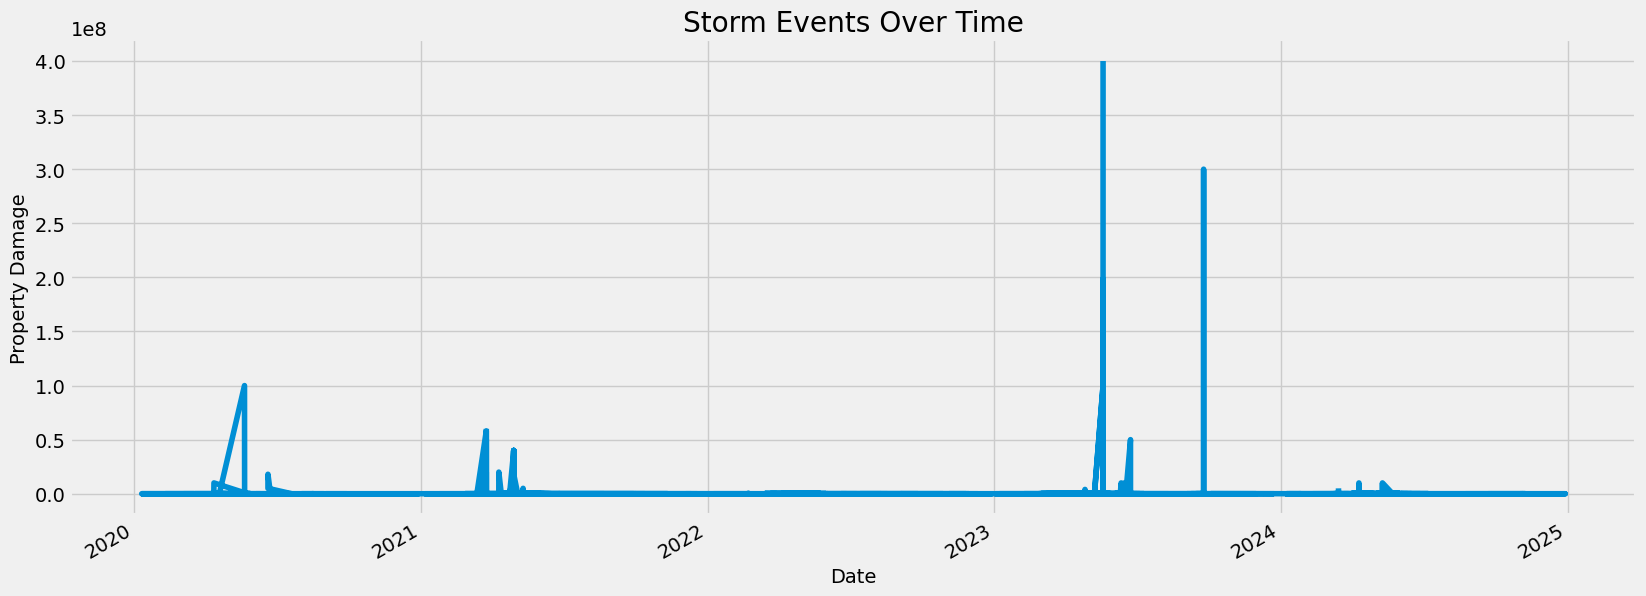

In [27]:
# Create a line chart with property damage over time
hail_tx_df.set_index('BEGIN_DATE_TIME')['DAMAGE_PROPERTY_NUMERIC'].plot(kind='line')
plt.title('Storm Events Over Time')
plt.xlabel('Date')
plt.ylabel('Property Damage')
plt.show()


In [28]:
# Set datetime field as the index
hail_tx_df.set_index('BEGIN_DATE_TIME', inplace=True)

In [29]:
# Resample monthly and count how many events per month
monthly_counts = hail_tx_df.resample('MS').size().to_frame(name='Hail_Event_Count')

In [30]:
# Set the frequency interval using month start
monthly_counts = monthly_counts.asfreq('MS').fillna(0)

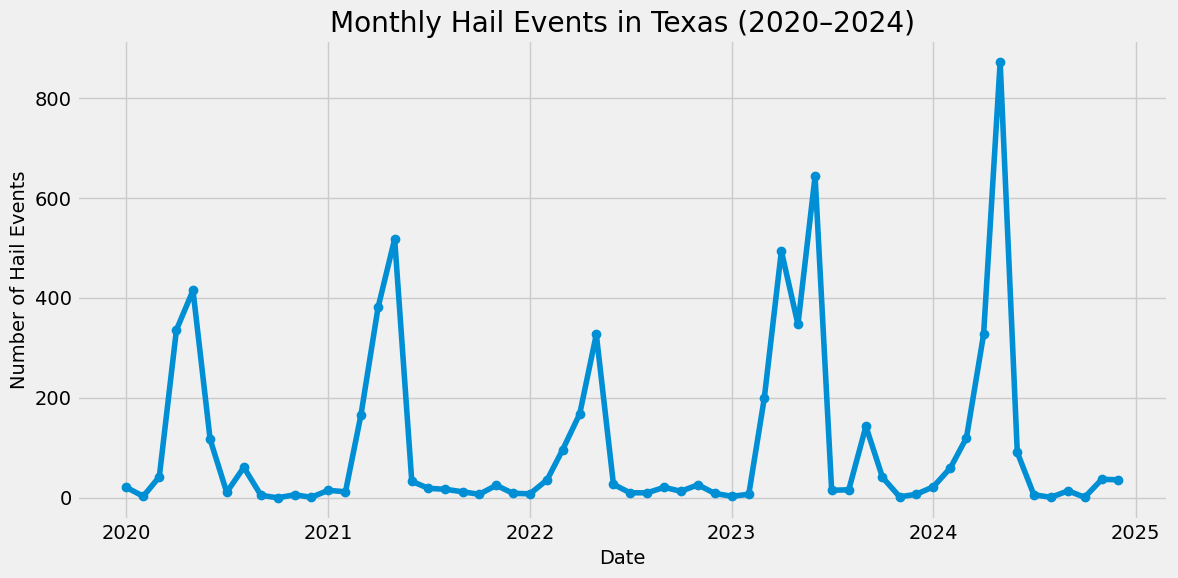

In [31]:
# Create a time series of monthly hail events
plt.figure(figsize=(12,6))
plt.plot(monthly_counts.index, monthly_counts['Hail_Event_Count'], marker='o')
plt.title('Monthly Hail Events in Texas (2020–2024)')
plt.xlabel('Date')
plt.ylabel('Number of Hail Events')
plt.grid(True)
plt.tight_layout()
plt.show()

### Decompose data

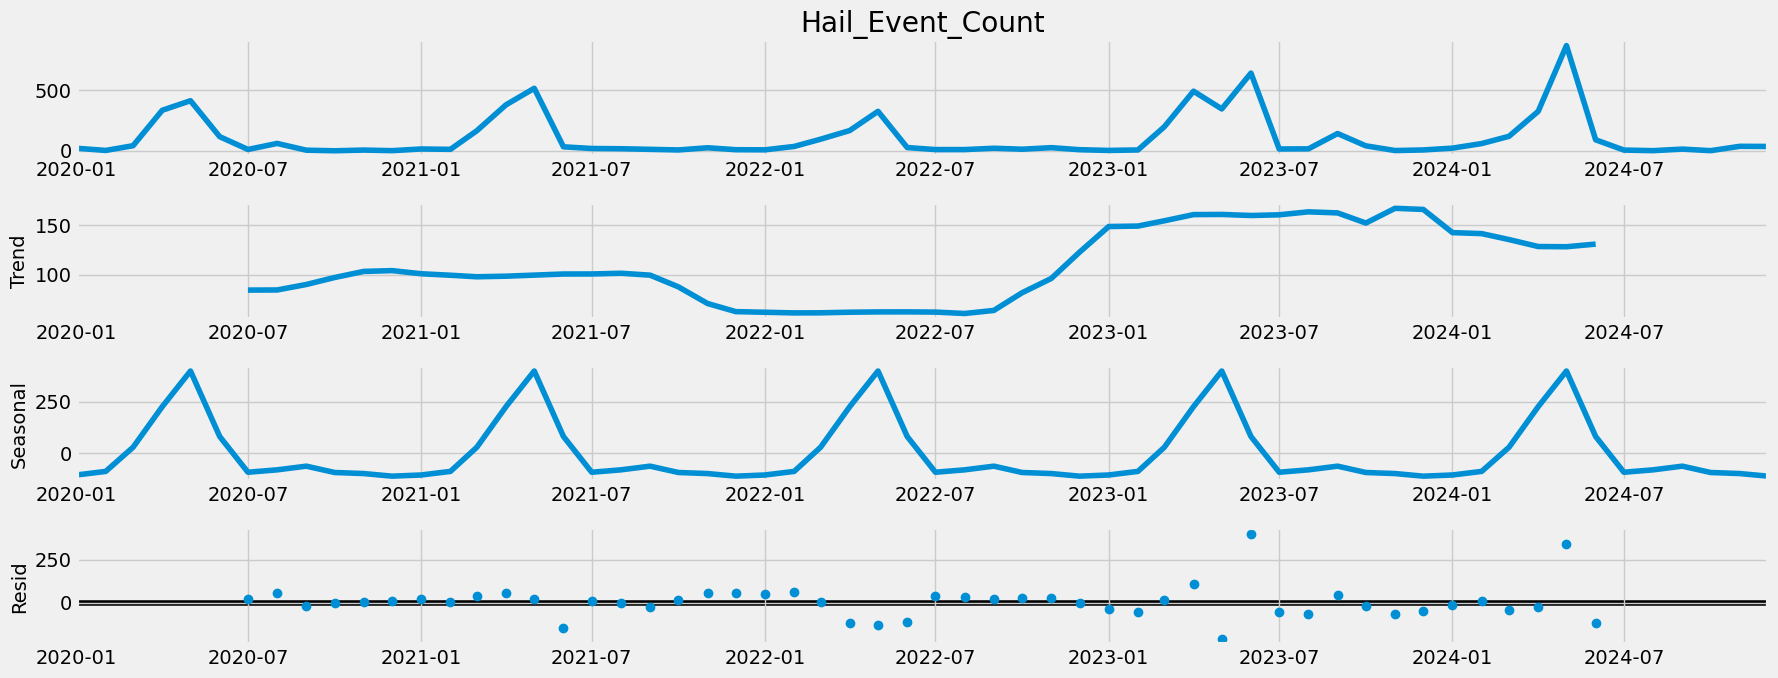

In [32]:
# decompose the data to see trends and seasonality
decomposition = seasonal_decompose(monthly_counts['Hail_Event_Count'], model='additive')
decomposition.plot()
plt.show()

# 4 Stationarity

In [33]:
def dickey_fuller(timeseries): # Define the function for testing for stationarity
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(monthly_counts['Hail_Event_Count'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.515181
p-value                         0.525988
Number of Lags Used            10.000000
Number of Observations Used    49.000000
Critical Value (1%)            -3.571472
Critical Value (5%)            -2.922629
Critical Value (10%)           -2.599336
dtype: float64


### Interpretation
##### Null hypothesis: the data is not stationary.
p-value (0.526) is much higher than 0.05. and the test statistic (-1.515) is not less than any of the critical values (especially not at 5% or 1%). This means we fail to reject the null hypothesis. That is, the data is not stationary, likely because it has seasonality (which would be expected of weather patterns.)

The next step is differencing, to achieve stationarity.

### Differencing

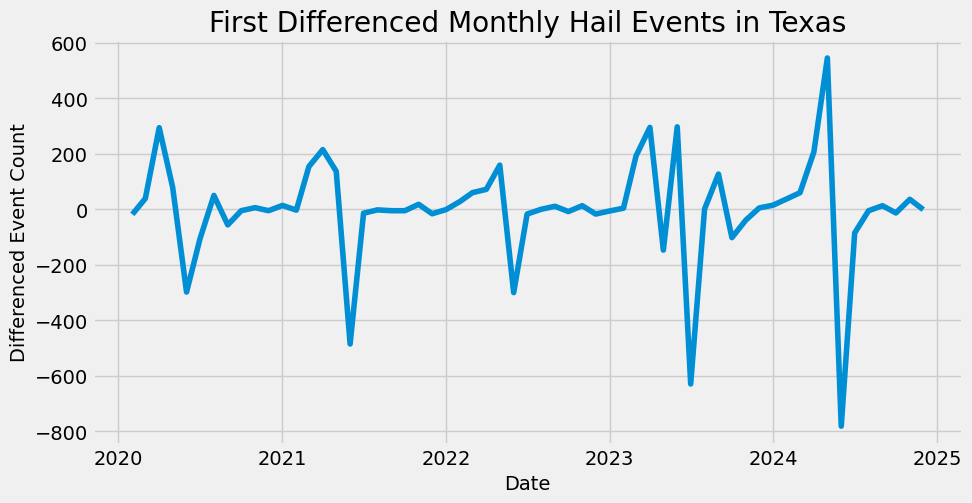

In [34]:
# Apply first differencing
monthly_diff = monthly_counts['Hail_Event_Count'].diff().dropna()

# Plot the differenced series
plt.figure(figsize=(10,5))
plt.plot(monthly_diff)
plt.title('First Differenced Monthly Hail Events in Texas')
plt.xlabel('Date')
plt.ylabel('Differenced Event Count')
plt.show()

In [35]:
# Rerun the dickey-fuller test
result = adfuller(monthly_diff)
print('Dickey-Fuller Test Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

Dickey-Fuller Test Statistic: -5.35327485386986
p-value: 4.242944666498942e-06
Critical Value (1%): -3.5778480370438146
Critical Value (5%): -2.925338105429433
Critical Value (10%): -2.6007735310095064


Test Statistic (-5.353) is much lower than the critical values. Since the test statistic is less than the critical values, it suggests strong evidence against the null hypothesis. The p-value is very small (much smaller than 0.05), so it also strongly suggests rejecting the null hypothesis of non-stationarity. The data is now stationary.

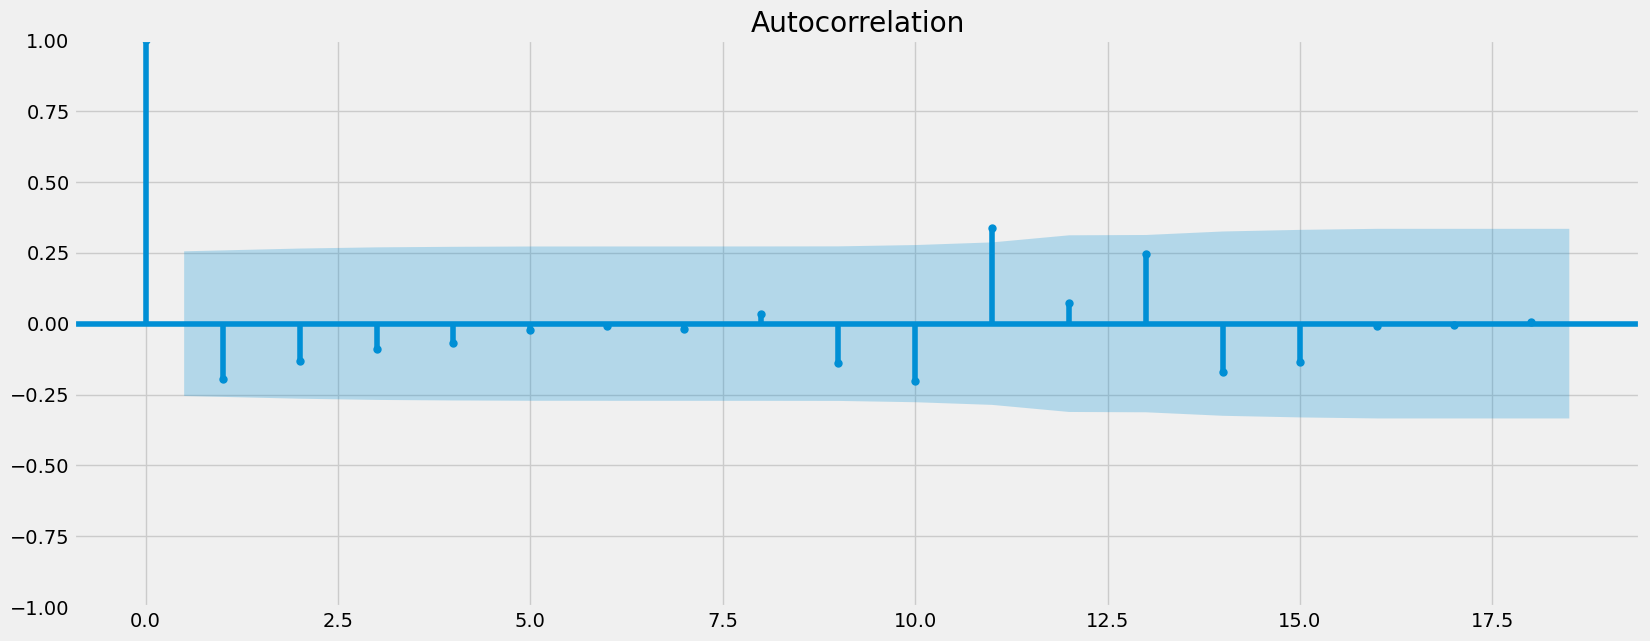

In [36]:
# check for autocorrelation
plot_acf(monthly_diff)
plt.show()

The differenced data does not show a high degree of autocorrelation.